# Tanzanian Water Wells

## Overview

Tanzania struggles with providing clean water to the people of its country. The goal of this analysis is to use data from existing wells throughout the country to identify the wells in need of repair. 

This analysis is focused on assisting the Tanzanian Government reduce resources spent to identify water wells that are in need of repair to ensure that clean water is available to its citizens. 

**Important Note:** Due to the runtime of some models in this notebook, the code has been commented out. I have included screenshots of the model results in each section with code that has been commented out but have kept the code to better show the steps taken to reach my end results.

If you are looking to run the entire notebook, including the models that require intense processing and time commitments, please head down to the 'Modeling' section and uncomment the code first.

# Import Libraries and Data 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import StandardScaler, OneHotEncoder, \
FunctionTransformer, normalize, PolynomialFeatures, LabelEncoder

from sklearn.linear_model import LinearRegression, LogisticRegression, \
Ridge, Lasso, ElasticNet, LassoCV, RidgeCV, ElasticNetCV

from sklearn.model_selection import train_test_split, cross_validate,\
KFold, cross_val_score, ShuffleSplit, RandomizedSearchCV, GridSearchCV

from sklearn.metrics import mean_squared_error, make_scorer, log_loss, \
confusion_matrix, plot_confusion_matrix, precision_score, recall_score, \
accuracy_score, f1_score, roc_curve, roc_auc_score, classification_report, auc, plot_roc_curve

from sklearn.dummy import DummyRegressor, DummyClassifier

from sklearn.utils import resample

from sklearn.impute import MissingIndicator, SimpleImputer

from sklearn.feature_selection import SelectFromModel

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

from sklearn import tree

from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

from scipy import stats
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer,  make_column_selector as selector

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
ExtraTreesClassifier, VotingClassifier, StackingRegressor, StackingClassifier

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

from sklearn.svm import SVC, NuSVC

from sklearn.cluster import KMeans

import xgboost

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImPipeline

%matplotlib inline


The data was provided by DrivenData.org in partnership with Taarifa who aggregated the data from the Tanzanian Ministry of Water.

In [2]:
X_data_df = pd.read_csv('data/x_data.csv')
y_data_df = pd.read_csv('data/target_data.csv')

# Data Understanding and Preparation

To better understand the data, I have reviewed the features and separated them into numerical and categorical feature types:

**Numerical:**
- `id` - Unique identifier
- `amount_tsh` - Total static head (amount water available to waterpoint)
- `gps_height` - Altitude of the well
- `longitude` - GPS coordinate
- `latitude` - GPS coordinate
- `num_private` - Number private
- `population` - Population around the well
- `construction_year` - Year the waterpoint was constructed

**Categorical:**
- `installer` - Organization that installed the well
- `wpt_name` - Name of the waterpoint if there is one
- `basin` - Geographic water basin
- `subvillage` - Geographic location
- `lga` - Geographic location
- `ward` - Geographic location
- `public_meeting` - True/False
- `scheme_management` - Who operates the waterpoint
- `permit` - If the waterpoint is permitted
- `extraction_type` - The kind of extraction the waterpoint uses
- `extraction_type_group` - The kind of extraction the waterpoint uses
- `extraction_type_class` - The kind of extraction the waterpoint uses
- `management` - How the waterpoint is managed
- `management_group` - How the waterpoint is managed
- `payment` - What the water costs
- `payment_type` - What the water costs
- `water_quality` - The quality of the water
- `quality_group` - The quality of the water
- `quantity` - The quantity of water
- `quantity_group` - The quantity of water
- `source` - The source of the water
- `source_type` - The source of the water
- `source_class` - The source of the water
- `waterpoint_type` - The kind of waterpoint
- `waterpoint_type_group` - The kind of waterpoint
- `region_code` - Geographic location (coded)
- `district_code` - Geographic location (coded)
- `scheme_name` - Who operates the waterpoint 
- `date_recorded` - The date the row was entered
- `funder` - Who funded the well
- `region` - Geographic location
- `recorded_by` - Group entering this row of data
- `target` - The current status of the waterpoint

The dataset used for this analysis has 40 features (including the target feature), and 59,400 rows of data. The target feature is separated into three classifications:

- 0 = Functional
- 1 = Functional Needs Repair
- 2 = Non-Functional

## Label Encode Target Variables

To better define the status of each well for this analysis, I have set up a binary system for the wells:
- 0 = Functional
- 1 = Needs Repair

In [3]:
y_encoded = pd.DataFrame(LabelEncoder().fit_transform(y_data_df['status_group']))

In [4]:
y_encoded.value_counts(normalize=True)

0    0.543081
2    0.384242
1    0.072677
dtype: float64

In [5]:
y_encoded = y_encoded.replace(2, 1)

In [6]:
y_encoded.value_counts(normalize=True)

0    0.543081
1    0.456919
dtype: float64

We can see that the data has a relatively even distribution. As such, we will not need to use any over sampling or under sampling techniques to get an even representation between the classifications.

## Bringing the Data Together

When running machine learning algorithms, its important to separate the predictor and target variables in order to train the model. The provided data is already separate, but in order to clean the data, I will be dropping a few rows that have missing information. 

To ensure that the predictor and target variables are still in line, I need to combine the datasets before dropping any rows with missing information.

In [7]:
df = pd.concat([X_data_df, y_encoded], axis=1)

In [8]:
# Giving the target column a name
df.rename(mapper={0:'target'}, axis=1, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

## Dropping Columns

To ensure that we are reducing the noise in the dataset while simultaneously being cognizant of computing time, we are removing a few columns that are not relevant to this analysis:

- `scheme_name` - Who operates the waterpoint.
    - This feature is missing a lot of data and the operator of the well should no impact the functionality of the well.
- `id` - A unique identifier number for each well.
    - The id code will not impact the well's functionality.
- `date_recorded` - The date the row was entered.
    - This is just data for when the information was recorded. This shouldn't have an effect on the well's functionality. 
- `funder` - Who funded the well.
    - Who paid for the well should not impact the functionality of the well.
- `recorded_by` - Group entering this row of data.
    - The group who's taking notes on the wells would not affect the data itself.
- `wpt_name` - Name of the waterpoint if there is one.
    - Similar to `id`, the name of the waterpoint should not affect the functionality.
- `region` - Geographic location.
    - The regional location of the well is already recorded through the feature `region_code`.

In [10]:
cols_to_drop = ['scheme_name', 'id', 'date_recorded', 'region', 'funder', 'recorded_by'
                , 'wpt_name', 'subvillage', 'ward', 'lga', 'basin', 'quality_group', 'quantity_group']
df_dropped = df.drop(cols_to_drop, axis=1)

adding in wpt name and subvillage cause there's a billion unique values and ohe is huge

maybe also add ward if still taking forever

and if stilllll taking forever add installer but that might have an actual affect...

## Addressing Missing Values

The `subvillage` feature is only missing data for 371 rows and it has 19,287 unique values. With the wide range of unique values and relatively little information missing, I will just drop those rows from the dataset.

The remaining features will have their information imputed based on the most frequent value in each category. I have decided to impute rather than drop the rows because each of the remaining features with missing values has a clearly identified 'most frequent' unique value. Also, in order to maintain the size and integrity of the dataset.

In order to avoid potential data leakage from imputing these values, they will be replaced later in this analysis through a pipeline after splitting training and test data.

In [11]:
df_dropped.nunique()

amount_tsh                  98
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
num_private                 65
region_code                 27
district_code               20
population                1049
public_meeting               2
scheme_management           12
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quantity                     5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
target                       2
dtype: int64

In [12]:
df_dropped.isna().sum()

amount_tsh                  0
gps_height                  0
installer                3655
longitude                   0
latitude                    0
num_private                 0
region_code                 0
district_code               0
population                  0
public_meeting           3334
scheme_management        3877
permit                   3056
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quantity                    0
source                      0
source_type                 0
source_class                0
waterpoint_type             0
waterpoint_type_group       0
target                      0
dtype: int64

In [13]:
# df_dropped = df_dropped.dropna(subset=['subvillage'])

## Column Dtypes

This dataset contains a wide variety of informational types. For the purpose of this analysis, I have recategorized two features from numerical types to categorical:

- `region_code`: A codified descriptor for the waterpoint's region.
- `district_code`: A codified descriptor for the waterpoint's district.

In [14]:
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   gps_height             59400 non-null  int64  
 2   installer              55745 non-null  object 
 3   longitude              59400 non-null  float64
 4   latitude               59400 non-null  float64
 5   num_private            59400 non-null  int64  
 6   region_code            59400 non-null  int64  
 7   district_code          59400 non-null  int64  
 8   population             59400 non-null  int64  
 9   public_meeting         56066 non-null  object 
 10  scheme_management      55523 non-null  object 
 11  permit                 56344 non-null  object 
 12  construction_year      59400 non-null  int64  
 13  extraction_type        59400 non-null  object 
 14  extraction_type_group  59400 non-null  object 
 15  ex

In [15]:
to_object = ['region_code', 'district_code']
df_clean = df_dropped.copy()

for obj in to_object:
    df_clean[obj] = df_clean[obj].astype(object)

We now have perfectly clean data with no data leakage:

- The target variable has been Label Encoded.
- Dropped irrelevant columns.
- Dropped rows with missing data for `subvillage`.
- Column Dtypes have been reassigned for categorical columns.

## Separating the Data

Now that the dataset has been cleaned we can begin the final preparations before beginning modeling. First, we need to separate the predictor and target variables again, then split the data into training and test groups.

In [16]:
y = df_clean['target']
X = df_clean.drop(['target'], axis =1)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Setting up Pipelines

To streamline the analysis, reduce the potential for data leakage, and ensure that all preprocessing steps are completed with each model, I have set up a pipeline. The pipeline begins by separating the numerical data from the categorical data, once separate, the two types of data can undergo their respective preprocessing.

- Numerical Data:
    - The columns for numerical data or not missing any values so there is no need to include an imputer.
    - Standard Scaler is being utilized to standardize and scale all numerical data.

- Categorical Data:
    - SimpleImputer is being utilized to fill missing data in the categorical columns based on the most frequent value within that column. A 'missing' indicator is in place to help identify that the data was not originally found within the dataset.
    - OneHotEncoding is being utilized to convert the categorical information to a binary system for modeling. 

In [18]:
num_pipe = Pipeline([
    ('ss', StandardScaler())
])

In [19]:
cat_pipe = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [20]:
ColTrans = ColumnTransformer(transformers=[
    ('num_pipe', num_pipe, selector(dtype_include=np.number)),
    ('cat_pipe', cat_pipe, selector(dtype_include=object))
], remainder='passthrough')

# Modeling

## First Simple Model

To begin analysis of the data, I have set up a first simple model to compare later models to. This is the bare minimum model that predicts that the most frequent target variable is the answer for all inputs. 

The first simple model has an accuracy of .535. 

In [21]:
dummy_model = Pipeline([
    ('ColTrans', ColTrans),
    ('dummy', DummyClassifier(strategy='most_frequent', random_state=42))
])

In [22]:
dummy_model.fit(X_train, y_train);

In [23]:
y_test.value_counts(normalize=True)

0    0.54532
1    0.45468
Name: target, dtype: float64

In [24]:
dummy_model.score(X_test, y_test)

0.5453198653198653

In [25]:
dummy_y_score = dummy_model.predict_proba(X_test)

In [26]:
roc_auc_score(y_test,dummy_y_score[:,1])

0.5

## Baseline Models

Now that the first simple model has been established, I need to create baseline models for each of the Machine Learning Algorithms I plan to use. These baseline models will act as a benchmark as I later tune the hyperparameters to try and improve the model results.

I will use the following methods during this analysis:
   - Logistic Regression
   - K-Nearest Neighbors
   - Decision Trees
   - Random Forests
   - C-Support Vector Classification (SVC)
   - Nu-Support Vector Classification (NuSVC)
   - Adaboost
   - Xgboost
   - Stack Classification Methods

### Helper Class

Since I will be running multiple models throughout the analysis, I have created a helper function to streamline the process.

In [27]:
class ModelRuns():
    ''' Class to easily run models through and determine output.'''
    
    def __init__(self, model, model_name, X, y):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        
    def cross_val(self, X=None, y=None, cv=5):
        cv_X= X if X else self.X
        cv_y = y if y else self.y
        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=cv)
        self.cv_mean = np.mean(self.cv_results)
        return print(f"Cross_val mean is: {round(self.cv_mean, 4)} for kfold: {cv}")
                
    def accuracy(self, X, y):
        acc = self.model.score(X, y)
        
    def performance(self, X, y):
        y_pred = self.model.predict(X)
        report = classification_report(y, y_pred)
        return report
    
    def class_matrix(self, X, y):
        mat = plot_confusion_matrix(self.model, X, y);
        if X is X_train:
            plt.title("Train")
        elif X is X_test:
            plt.title('Test')
        else:
            plt.title('Class Matrix')
        return mat
    
    def roc_auc_custom(self, X, y):
        y_score = self.model.predict_proba(X)
        roc_score = roc_auc_score(y, y_score[:,1])
        return roc_score
    
    def run_all(self, X_train_run=X_train, X_test_run=X_test, y_train_run=y_train, y_test_run=y_test, train_results=True):
        if train_results:
            y_train_perf = self.performance(X_train_run, y_train_run)
            y_train_auc = self.roc_auc_custom(X_train_run, y_train_run)
            y_test_perf = self.performance(X_test_run, y_test_run)
            y_test_auc = self.roc_auc_custom(X_test_run, y_test_run)
            train_matrix = self.class_matrix(X_train_run, y_train_run)
            test_matrix = self.class_matrix(X_test_run, y_test_run)
            return print(f"Train Report: \n{y_train_perf}\nAUC-ROC Score:{y_train_auc}\n"), \
            print(f"Test Report: \n{y_test_perf}\nAUC-ROC Score:{y_test_auc}")
        else:
            y_test_perf = self.performance(X_test_run, y_test_run)
            test_matrix = self.class_matrix(X_test_run, y_test_run)
            return print(f"Test Report: \n{y_test_perf}")

In [28]:
# dummy_runs = ModelRuns(dummy_model, 'dummy', X_train, y_train)

In [29]:
# print(dummy_runs.performance(X_train, y_train))

In [30]:
# y_train.value_counts()

In [31]:
# dummy_runs.class_matrix(X_train, y_train);

In [32]:
# print(dummy_runs.performance(X_test, y_test))

In [33]:
# dummy_runs.class_matrix(X_test, y_test);

In [34]:
# dummy_runs.run_all();

## LogReg Pipe

In [35]:
log_reg_model = Pipeline([
    ('ColTrans', ColTrans),
    ('logreg', LogisticRegression(random_state=42))
])

In [36]:
log_reg_model.fit(X_train, y_train);

C:\Users\nacnu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
log_reg_pipe = ModelRuns(log_reg_model, 'logreg', X_train, y_train)

Train Report: 
              precision    recall  f1-score   support

           0       0.76      0.87      0.81     24161
           1       0.81      0.68      0.74     20389

    accuracy                           0.78     44550
   macro avg       0.78      0.77      0.77     44550
weighted avg       0.78      0.78      0.78     44550

AUC-ROC Score:0.852668202687885

Test Report: 
              precision    recall  f1-score   support

           0       0.75      0.86      0.80      8098
           1       0.79      0.67      0.72      6752

    accuracy                           0.77     14850
   macro avg       0.77      0.76      0.76     14850
weighted avg       0.77      0.77      0.77     14850

AUC-ROC Score:0.8435696796734085


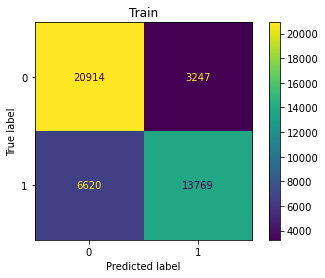

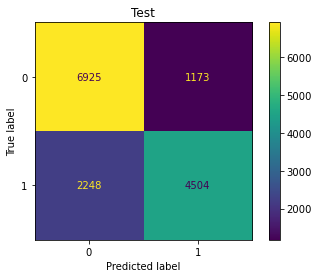

In [38]:
log_reg_pipe.run_all(train_results=True);

### LogReg Grid Search

In [41]:
# LogisticRegression(solver)

In [39]:
log_params = {
    'logreg__solver':['lbfgs', 'liblinear', 'sag', 'saga'],
#     'rfc__max_depth':[1,3,5],
}

In [40]:
log_reg_gs = GridSearchCV(estimator=log_reg_model, param_grid=log_params, cv=10, verbose=1)

In [70]:
log_reg_gs.fit(X_train, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\nacnu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\nacnu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternat

C:\Users\nacnu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\nacnu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\nacnu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\nacnu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\nacnu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ColTrans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipe',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000015C865B4460>),
                                                                        ('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(add_indicator=True,
                                                                             

In [71]:
log_reg_gs.best_params_

{'logreg__solver': 'liblinear'}

In [72]:
log_reg_gs.best_score_

0.7794837261503929

In [73]:
log_reg_gs.best_estimator_.score(X_test,y_test)

0.7784511784511785

Next iteration of gridsearch

In [ ]:
LogisticRegression()

In [74]:
log_params2 = {
    'logreg__solver':['liblinear', 'sag', 'saga'],
    'logreg__max_iter':[100, 200, 500, 1000],
}

In [75]:
log_reg_gs2 = GridSearchCV(estimator=log_reg_model, param_grid=log_params2, cv=5, verbose=1)

In [ ]:
log_reg_gs2.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\nacnu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\nacnu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\nacnu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\nacnu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which

C:\Users\nacnu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


## KNN Model

Setting up kmeans cluster to group the data into 8 clusters based on proximity

In [28]:
kmeans_model = Pipeline([
    ('ColTrans', ColTrans),
    ('kmeans', KMeans(n_clusters=7, random_state=42))
])

In [29]:
# Fitting the model
kmeans_model.fit(X_train, y_train);

In [30]:
# creating a dataframe for X_train so I can house the cluster data
kmeans_X_train_df = pd.DataFrame(X_train)

In [31]:
# predicting data before adding back the target var so there is no data leakage 
kmeans_X_train_df['cluster'] = kmeans_model.predict(X_train)

In [32]:
# adding the target variable back so that I can then separate into dfs based on clusters
kmeans_X_train_df['target'] = y_train

In [33]:
# creating 8 new dataframes based on clusters and storing in a dictionary
df_names = ['kmeans_0', 'kmeans_1', 'kmeans_2', 'kmeans_3', 'kmeans_4', 'kmeans_5', 'kmeans_6']
kmeans_train_dic = {}
for i, name in enumerate(df_names):
    print(name)
    kmeans_train_dic[name] = kmeans_X_train_df[kmeans_X_train_df['cluster'] == i]

kmeans_0
kmeans_1
kmeans_2
kmeans_3
kmeans_4
kmeans_5
kmeans_6


In [34]:
# need to seperate x, y vars now
y_kmeans_train_dic = {}
for name in df_names:
    y_kmeans_train_dic[name] = kmeans_train_dic[name].pop('target')

In [35]:
kmeans_train_dic['kmeans_0'].head()

,amount_tsh,gps_height,installer,longitude,latitude,num_private,region_code,district_code,population,public_meeting,...,payment,payment_type,water_quality,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,cluster
24947,20.0,330,Ce,38.123839,-6.087137,0,6,1,80,True,...,pay per bucket,per bucket,salty,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,0
6973,30.0,933,SHAWASA,36.858826,-3.605154,0,21,4,200,True,...,pay per bucket,per bucket,salty,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,0
65,0.0,1415,NaN,34.621598,-5.173136,0,13,2,1,True,...,unknown,unknown,unknown,dry,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,0
12481,0.0,269,RWE,36.683614,-8.077109,0,5,3,500,True,...,never pay,never pay,soft,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,0
27337,20.0,1726,Village Council,35.021166,-4.195571,0,21,3,231,True,...,pay per bucket,per bucket,soft,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,0


In [36]:
y_kmeans_train_dic['kmeans_0'].head()

24947    1
6973     0
65       1
12481    1
27337    0
Name: target, dtype: int32

^^^ This is it. I have created a dic of data frames for x and y vars based on clusters

Now to do the same thing for the test data

In [37]:
# creating a dataframe for X_test so I can house the cluster data
kmeans_X_test_df = pd.DataFrame(X_test)

In [38]:
# predicting data before adding back the target var so there is no data leakage 
kmeans_X_test_df['cluster'] = kmeans_model.predict(X_test)

In [39]:
# adding the target variable back so that I can then separate into dfs based on clusters
kmeans_X_test_df['target'] = y_test

In [40]:
# creating 8 new dataframes based on clusters and storing in a dictionary
kmeans_test_dic = {}
for i, name in enumerate(df_names):
    print(name)
    kmeans_test_dic[name] = kmeans_X_test_df[kmeans_X_test_df['cluster'] == i]

kmeans_0
kmeans_1
kmeans_2
kmeans_3
kmeans_4
kmeans_5
kmeans_6


In [41]:
# need to seperate x, y vars now
y_kmeans_test_dic = {}
for name in df_names:
    y_kmeans_test_dic[name] = kmeans_test_dic[name].pop('target')

Setting up KNN on train test data for each cluster

In [42]:
knn_model = Pipeline([
    ('ColTrans', ColTrans),
    ('knn', KNeighborsClassifier())
])

In [43]:
model_dic = {}
for name in df_names:
    model_dic[name] = knn_model.fit(kmeans_train_dic[name], y_kmeans_train_dic[name])

In [44]:
knn_test_scores = {}
for name in df_names:
    knn_test_scores[name] = model_dic[name].score(kmeans_test_dic[name], y_kmeans_test_dic[name])

In [45]:
knn_test_scores

{'kmeans_0': 0.5360590573537762,
 'kmeans_1': 0.40615773935048505,
 'kmeans_2': 0.4532627865961199,
 'kmeans_3': 0.5283344851416725,
 'kmeans_4': 0.5039914848323577,
 'kmeans_5': 0.3445692883895131,
 'kmeans_6': 0.8118393234672304}

In [46]:
np.mean(list(knn_test_scores.values()))

0.5120305950187364

In [52]:
main_col = ['cluster_group']
kmeans_results_df = pd.DataFrame(knn_test_scores.keys(), columns=main_col)

In [53]:
kmeans_results_df['clusters=7'] = knn_test_scores.values()

In [54]:
kmeans_results_df

,cluster_group,clusters=7
0,kmeans_0,0.536059
1,kmeans_1,0.406158
2,kmeans_2,0.453263
3,kmeans_3,0.528334
4,kmeans_4,0.503991
5,kmeans_5,0.344569
6,kmeans_6,0.811839


Now gonna try and make it a loop to get them all in here

In [96]:
df_names = ['kmeans_0', 'kmeans_1', 'kmeans_2', 'kmeans_3', 'kmeans_4', 'kmeans_5', 'kmeans_6']
main_col = ['cluster_group']
kmeans_results_df = pd.DataFrame(df_names, columns=main_col)

for i in range(1,7):
    kmeans_model = Pipeline([
        ('ColTrans', ColTrans),
        ('kmeans', KMeans(n_clusters=i, random_state=42))
    ])
    
    
    # Fitting the model
    kmeans_model.fit(X_train, y_train);
    
    # creating a dataframe for X_train so I can house the cluster data
    kmeans_X_train_df = pd.DataFrame(X_train)
    
    
    # predicting data before adding back the target var so there is no data leakage 
    kmeans_X_train_df['cluster'] = kmeans_model.predict(X_train)

    
    # adding the target variable back so that I can then separate into dfs based on clusters
    kmeans_X_train_df['target'] = y_train
    
#     print(kmeans_X_train_df)
    
    # creating new dataframes based on clusters and storing in a dictionary
    kmeans_train_dic = {}
    for x in range(i-i, i):
#         print(x)
#         print(df_names[x])
#         print(kmeans_X_train_df[kmeans_X_train_df['cluster'] == x])
        kmeans_train_dic[df_names[x]] = kmeans_X_train_df[kmeans_X_train_df['cluster'] == x]

        
    # need to seperate x, y vars now
    y_kmeans_train_dic = {}
    for x in range(i-i, i):
        y_kmeans_train_dic[df_names[x]] = kmeans_train_dic[df_names[x]].pop('target') 
        
    # creating a dataframe for X_test so I can house the cluster data
    kmeans_X_test_df = pd.DataFrame(X_test)
    
    # predicting data before adding back the target var so there is no data leakage 
    kmeans_X_test_df['cluster'] = kmeans_model.predict(X_test)
    
    # adding the target variable back so that I can then separate into dfs based on clusters
    kmeans_X_test_df['target'] = y_test
    
    
    # creating new dataframes based on clusters and storing in a dictionary
    kmeans_test_dic = {}
    for x in range(i-i, i):
#         print(df_names[x])
        kmeans_test_dic[df_names[x]] = kmeans_X_test_df[kmeans_X_test_df['cluster'] == x]
        
    # need to seperate x, y vars now
    y_kmeans_test_dic = {}
    for x in range(i-i, i):
        y_kmeans_test_dic[df_names[x]] = kmeans_test_dic[df_names[x]].pop('target')
        
#     print(kmeans_train_dic)    
#     print(kmeans_test_dic)    
        
    # It works above this point
    # running the knn model on each cluster
    knn_model = Pipeline([
        ('ColTrans', ColTrans),
        ('knn', KNeighborsClassifier())
    ])
    
    # creating a dic to story each fitted model
    model_dic = {}
    for x in range(0, i):
        model_dic[df_names[x]] = knn_model.fit(kmeans_train_dic[df_names[x]], y_kmeans_train_dic[df_names[x]])
        
    # Creating a dic to store test scores
    knn_test_scores = {}
    for x in range(0, i):
        knn_test_scores[df_names[x]] = model_dic[df_names[x]].score(kmeans_test_dic[df_names[x]], y_kmeans_test_dic[df_names[x]])
        
    # creating a dataframe to store all test scores
#     main_col = ['cluster_group']
#     kmeans_results_df = pd.DataFrame(knn_test_scores.keys(), columns=main_col)
    
    # appending each itteration to df
    addition = pd.DataFrame({
        f'clusters={i}':  knn_test_scores.values()})
    
    kmeans_results_df = pd.concat([kmeans_results_df, addition], axis=1)

In [97]:
kmeans_results_df

,cluster_group,clusters=5,clusters=6
0,kmeans_0,0.562655,0.572057
1,kmeans_1,0.613092,0.663873
2,kmeans_2,0.579281,0.615307
3,kmeans_3,0.615813,0.556335
4,kmeans_4,0.786278,0.579281
5,kmeans_5,NaN,0.786278
6,kmeans_6,NaN,NaN


## Decision Tree Pipe

In [39]:
dtc_model = Pipeline([
    ('ColTrans', ColTrans),
    ('dtc', DecisionTreeClassifier(random_state=42))
])

In [40]:
dtc_model.fit(X_train, y_train);

In [41]:
dtc_pipe = ModelRuns(dtc_model, 'dtc', X_train, y_train)

Train Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24161
           1       1.00      0.99      1.00     20389

    accuracy                           1.00     44550
   macro avg       1.00      1.00      1.00     44550
weighted avg       1.00      1.00      1.00     44550

AUC-ROC Score:0.9999650886121889

Test Report: 
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      8098
           1       0.76      0.76      0.76      6752

    accuracy                           0.78     14850
   macro avg       0.78      0.78      0.78     14850
weighted avg       0.78      0.78      0.78     14850

AUC-ROC Score:0.781845379878479


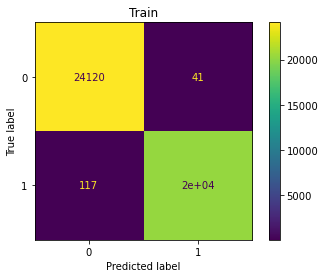

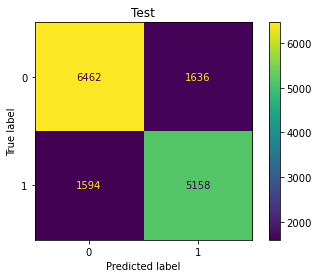

In [42]:
dtc_pipe.run_all(train_results=True);

## Random Forest

In [43]:
rf_model = Pipeline([
    ('ColTrans', ColTrans),
    ('rf', RandomForestClassifier(random_state=42))
])

In [44]:
rf_model.fit(X_train, y_train);

In [45]:
rf_pipe = ModelRuns(rf_model, 'rf', X_train, y_train)

Train Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24161
           1       1.00      0.99      1.00     20389

    accuracy                           1.00     44550
   macro avg       1.00      1.00      1.00     44550
weighted avg       1.00      1.00      1.00     44550

AUC-ROC Score:0.9995039225363929

Test Report: 
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      8098
           1       0.81      0.77      0.79      6752

    accuracy                           0.82     14850
   macro avg       0.82      0.81      0.81     14850
weighted avg       0.82      0.82      0.82     14850

AUC-ROC Score:0.8939694807184269


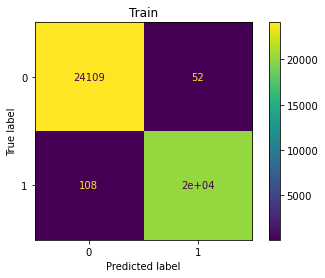

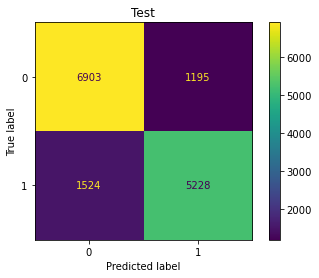

In [46]:
rf_pipe.run_all(train_results=True);

## SVC

In [57]:
SVC_model = Pipeline([
    ('ColTrans', ColTrans),
    ('SVC', SVC(random_state=42))
])

In [ ]:
SVC_model.fit(X_train, y_train);

In [ ]:
SVC_pipe = ModelRuns(SVC_model, 'svc', X_train, y_train)

In [ ]:
SVC_pipe.run_all(train_results=True);

## NuSVC

In [47]:
nu_model = Pipeline([
    ('ColTrans', ColTrans),
    ('SVC', NuSVC(random_state=42))
])

In [ ]:
nu_model.fit(X_train, y_train);

In [ ]:
nu_pipe = ModelRuns(nu_model, 'NuSVC', X_train, y_train)

In [ ]:
nu_pipe.run_all(train_results=True);

## Adaboost

In [47]:
ada_model = Pipeline([
    ('ColTrans', ColTrans),
    ('ada', AdaBoostClassifier(random_state=42))
])

In [48]:
ada_model.fit(X_train, y_train);

In [49]:
ada_pipe = ModelRuns(ada_model, 'ada', X_train, y_train)

Train Report: 
              precision    recall  f1-score   support

           0       0.73      0.86      0.79     24161
           1       0.79      0.63      0.70     20389

    accuracy                           0.75     44550
   macro avg       0.76      0.74      0.75     44550
weighted avg       0.76      0.75      0.75     44550

AUC-ROC Score:0.8292228215754301

Test Report: 
              precision    recall  f1-score   support

           0       0.73      0.85      0.79      8098
           1       0.78      0.62      0.69      6752

    accuracy                           0.75     14850
   macro avg       0.76      0.74      0.74     14850
weighted avg       0.75      0.75      0.74     14850

AUC-ROC Score:0.8239995152685292


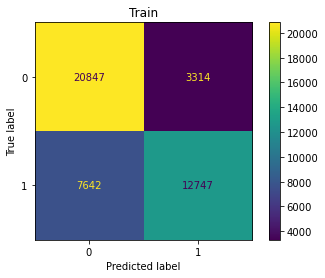

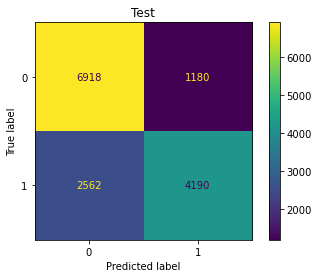

In [50]:
ada_pipe.run_all(train_results=True);

## XGBoost

In [51]:
xgb_model = Pipeline([
    ('ColTrans', ColTrans),
    ('xgb', xgboost.XGBClassifier(random_state=42))
])

In [52]:
xgb_model.fit(X_train, y_train);

In [53]:
xgb_pipe = ModelRuns(xgb_model, 'xgb', X_train, y_train)

Train Report: 
              precision    recall  f1-score   support

           0       0.80      0.91      0.85     24161
           1       0.88      0.73      0.80     20389

    accuracy                           0.83     44550
   macro avg       0.84      0.82      0.83     44550
weighted avg       0.84      0.83      0.83     44550

AUC-ROC Score:0.9143211644560036

Test Report: 
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      8098
           1       0.83      0.70      0.76      6752

    accuracy                           0.80     14850
   macro avg       0.81      0.79      0.79     14850
weighted avg       0.80      0.80      0.80     14850

AUC-ROC Score:0.8831592501629916


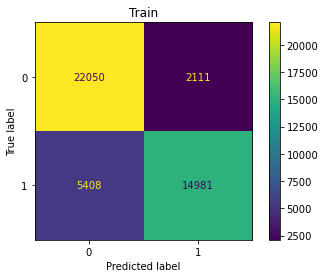

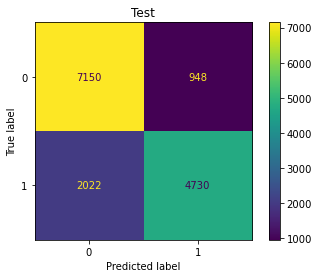

In [54]:
xgb_pipe.run_all(train_results=True);

## XGBoost Random Forest

In [55]:
xgbrf_model = Pipeline([
    ('ColTrans', ColTrans),
    ('xgbrf', xgboost.XGBRFClassifier(random_state=42))
])

In [56]:
xgbrf_model.fit(X_train, y_train);

In [57]:
xgbrf_pipe = ModelRuns(xgbrf_model, 'xgbrf', X_train, y_train)

Train Report: 
              precision    recall  f1-score   support

           0       0.80      0.91      0.85     24161
           1       0.88      0.73      0.80     20389

    accuracy                           0.83     44550
   macro avg       0.84      0.82      0.83     44550
weighted avg       0.84      0.83      0.83     44550

AUC-ROC Score:0.9143211644560036

Test Report: 
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      8098
           1       0.83      0.70      0.76      6752

    accuracy                           0.80     14850
   macro avg       0.81      0.79      0.79     14850
weighted avg       0.80      0.80      0.80     14850

AUC-ROC Score:0.8831592501629916


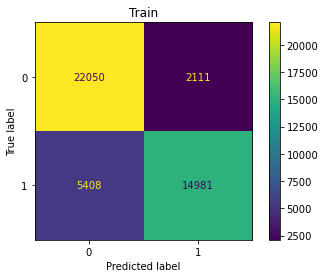

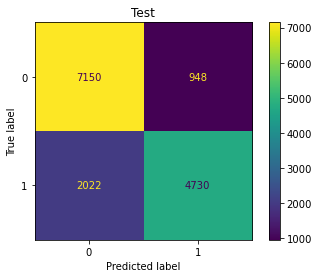

In [58]:
xgb_pipe.run_all(train_results=True);

## Stacking Regressor 

In [59]:
estimators = [
    ('lr', LogisticRegression(random_state=42, solver='liblinear')), 
#     ('knn', KNeighborsClassifier()),
    ('dtc', DecisionTreeClassifier(random_state=42)),
    ('rfc', RandomForestClassifier(random_state=42)),
    ('ada', AdaBoostClassifier(random_state=42)),
    ('xgb', xgboost.XGBClassifier(random_state=42)),
    ('xgbrf', xgboost.XGBRFClassifier(random_state=42))
]

In [60]:
stack_model = Pipeline([
    ('ColTrans', ColTrans),
    ('stack', StackingClassifier(estimators))
])

In [61]:
stack_model.fit(X_train, y_train);

In [63]:
stack_pipe = ModelRuns(stack_model, 'stack', X_train, y_train)

Train Report: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     24161
           1       0.97      0.95      0.96     20389

    accuracy                           0.96     44550
   macro avg       0.96      0.96      0.96     44550
weighted avg       0.96      0.96      0.96     44550

AUC-ROC Score:0.9956407089103404

Test Report: 
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      8098
           1       0.83      0.77      0.80      6752

    accuracy                           0.83     14850
   macro avg       0.83      0.82      0.82     14850
weighted avg       0.83      0.83      0.83     14850

AUC-ROC Score:0.9026553715796657


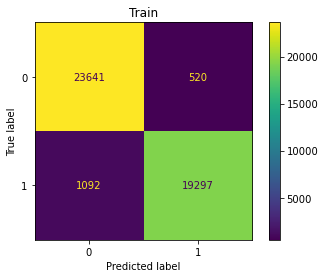

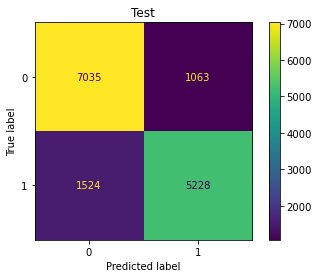

In [64]:
stack_pipe.run_all(train_results=True);

# Gridsearch